## Setup

In [1]:
# !python3.10 -m pip install boto3 psycopg2-binary matplotlib pandas openai==0.28 seaborn
# aws configure
# aws dynamodb describe-table --table-name clinical_notes
# aws dynamodb scan --table-name clinical_notes

In [2]:
# Read DynamoDB
import boto3, pandas as pd
from decimal import Decimal
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

def get_dynamo_connection():
    """
    Create DynamoDB connection using environment variables
    Returns DynamoDB table resource
    """
    return boto3.resource(
        "dynamodb",
        region_name=os.getenv("AWS_REGION", "us-west-2"),
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
    ).Table(os.getenv("DYNAMODB_TABLE", "clinical_notes"))

def conv(x):
    """Convert DynamoDB types to Python native types"""
    if isinstance(x, list):  return [conv(v) for v in x]
    if isinstance(x, dict):  return {k: conv(v) for k,v in x.items()}
    if isinstance(x, Decimal): return int(x) if x % 1 == 0 else float(x)
    return x

def read_dynamo_data(batch_size=10000):
    """
    Read data from DynamoDB in batches
    Returns pandas DataFrame
    """
    tbl = get_dynamo_connection()
    
    start_key = None
    batch = []
    all_batches = []
    
    while True:
        scan_kwargs = {}
        if start_key:
            scan_kwargs["ExclusiveStartKey"] = start_key
            
        resp = tbl.scan(**scan_kwargs)
        for item in resp.get("Items", []):
            batch.append(conv(item))
            if len(batch) >= batch_size:
                all_batches.append(pd.json_normalize(batch))
                batch.clear()
                
        start_key = resp.get("LastEvaluatedKey")
        if not start_key:
            break

    if batch:
        all_batches.append(pd.json_normalize(batch))
        
    return pd.concat(all_batches, ignore_index=True) if all_batches else pd.DataFrame()

# Read data from DynamoDB
dynamo_df = read_dynamo_data()
# dynamo_df


In [3]:
# Read Postgresql
import psycopg2, psycopg2.extras as extras

# PostgreSQL connection parameters from environment variables
conn = psycopg2.connect(
    dbname=os.getenv("POSTGRES_DB", "postgres"),
    user=os.getenv("POSTGRES_USER", "postgres"), 
    password=os.getenv("POSTGRES_PASSWORD"),
    host=os.getenv("POSTGRES_HOST"),
    port=os.getenv("POSTGRES_PORT", 5432),
)
conn.set_session(readonly=True, autocommit=False)

BATCH = int(os.getenv("POSTGRES_BATCH_SIZE", 10000))

frames = []
with conn:
    with conn.cursor() as ctl:
        ctl.execute("SET statement_timeout = 600000")

    with conn.cursor(name="stream_notes", cursor_factory=extras.RealDictCursor) as cur:
        cur.itersize = BATCH
        cur.execute('SELECT * FROM public.clinical_notes')

        while True:
            rows = cur.fetchmany(BATCH)
            if not rows:
                break
            frames.append(pd.DataFrame(rows))

postgre_df = pd.concat(frames, ignore_index=True)

In [4]:
for df in (dynamo_df, postgre_df):
    df["patient_id"] = df["patient_id"].astype(str)


dyn_cols_map = {
    "patient_id": "patient_id",
    "history_of_present_illness": "hpi",
    "original_transcript": "transcript",
    "assessment": "assessment",
    "plan": "plan",
    "ordered_medical_tests": "order",
    "reviewed_note": "note_reviewed",
    "coding_information": "summary",
    "soap_note": "note_ai",
    "audio_upload_date": "appt_date",
    "job_start_time": "job_start_time",
    "job_end_time": "job_end_time",
    "Doctor": "doctor_name",
    "reviewer_id": "reviewer_id",
    "icd10_codes.icd10_codes_res": "icd10_plain_codes",
    "icd10_codes.icd10_res": "icd10_named_codes",
    "icd10_codes_v2" : "icd10_codes_v2",
    "faithfulness_score" : "faithfulness_outof_1",
    "point_coverage_score" : "coverage_outof_1",
    "structured_score" : "structured_outof_1"
}
dyn_keep = [c for c in dyn_cols_map if c in dynamo_df.columns]
dyn_sel = dynamo_df[dyn_keep].rename(columns={k:v for k,v in dyn_cols_map.items() if k in dyn_keep}).copy()



pg_cols_map = {
    "patient_id": "patient_id",
    "hpi": "hpi",
    "description": "patient_name",
    "diarized_transcript": "transcript",
    "note": "note_ground_truth",
    "date_of_appt": "appt_date",
    "created_at": "created_at",
    "time_spent": "time_spent",
    "user_id": "user_id",
    "icd_10_codes":"icd10_codes",
    "icd10_codes_v2": "icd10_codes_v2"
}
pg_keep = [c for c in pg_cols_map if c in postgre_df.columns]
pg_sel = postgre_df[pg_keep].rename(columns={k:v for k,v in pg_cols_map.items() if k in pg_keep}).copy()


merged = pd.merge(dyn_sel, pg_sel, on="patient_id", how="inner", suffixes=("_dyn", "_pg"))

# list(merged.columns)

# Section 2: Note Quality Comparison System

In [5]:
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Any
import math
import difflib
import re
from collections import Counter, defaultdict

SECTION_KEYS = [
    "DATE OF VISIT",
    "PATIENT",
    "REFERRING PROVIDER",
    "CHIEF COMPLAINT",
    "HISTORY OF PRESENT ILLNESS",  # aka HPI
    "INTERVAL HISTORY",
    "ALLERGIES",
    "MEDICATIONS",
    "REVIEW OF SYSTEMS",           # aka ROS
    "OBJECTIVE",                   # aka Physical Examination / PE
    "ASSESSMENT",                  # aka Impression
    "PLAN",
    "CONSENT",
]

SECTION_ALIASES = {
    "DATE OF VISIT": "DATE OF VISIT",
    "DATE": "DATE OF VISIT",
    "PATIENT": "PATIENT",
    "REFERRING PROVIDER": "REFERRING PROVIDER",
    "REFERRING PHYSICIAN": "REFERRING PROVIDER",

    "CHIEF COMPLAINT": "CHIEF COMPLAINT",
    "CC": "CHIEF COMPLAINT",

    "HISTORY OF PRESENT ILLNESS": "HISTORY OF PRESENT ILLNESS",
    "HPI": "HISTORY OF PRESENT ILLNESS",
    "DISEASE HISTORY": "HISTORY OF PRESENT ILLNESS",

    "INTERVAL HISTORY": "INTERVAL HISTORY",

    "ALLERGIES": "ALLERGIES",
    "ALLERGY": "ALLERGIES",

    "MEDICATIONS": "MEDICATIONS",
    "MEDS": "MEDICATIONS",
    "CURRENT MEDICATIONS": "MEDICATIONS",

    "REVIEW OF SYSTEMS": "REVIEW OF SYSTEMS",
    "ROS": "REVIEW OF SYSTEMS",

    "OBJECTIVE": "OBJECTIVE",
    "PHYSICAL EXAMINATION": "OBJECTIVE",
    "PHYSICAL EXAM": "OBJECTIVE",
    "PE": "OBJECTIVE",
    "EXAM": "OBJECTIVE",

    "ASSESSMENT": "ASSESSMENT",
    "IMPRESSION": "ASSESSMENT",
    "A/P": "ASSESSMENT",  # common combined header; see note below

    "PLAN": "PLAN",

    "CONSENT": "CONSENT",
    "PRIVACY CONSENT": "CONSENT",
    "RECORDED CONSENT": "CONSENT",
}

# Precompile a regex that finds any of the headers (case-insensitive), supports inline content.
# Example it matches "CHIEF COMPLAINT: text..." and "HISTORY OF PRESENT ILLNESS:\n(more lines)"
HEADER_PATTERN = re.compile(
    r"(?im)^(?P<hdr>"
    r"DATE OF VISIT|DATE|PATIENT|REFERRING PROVIDER|REFERRING PHYSICIAN|"
    r"CHIEF COMPLAINT|CC|"
    r"HISTORY OF PRESENT ILLNESS|HPI|DISEASE HISTORY|"
    r"INTERVAL HISTORY|"
    r"ALLERGIES|ALLERGY|"
    r"MEDICATIONS|MEDS|CURRENT MEDICATIONS|"
    r"REVIEW OF SYSTEMS|ROS|"
    r"OBJECTIVE|PHYSICAL EXAMINATION|PHYSICAL EXAM|PE|EXAM|"
    r"ASSESSMENT|IMPRESSION|A/P|"
    r"PLAN|"
    r"CONSENT|PRIVACY CONSENT|RECORDED CONSENT"
    r")\s*:\s*(?P<after>[^\n]*)"
)

def _canonicalize_header(h: str) -> Optional[str]:
    key = re.sub(r"\s+", " ", h.strip().upper())
    return SECTION_ALIASES.get(key)

def normalize_text(s: str) -> str:
    return re.sub(r"\s+", " ", s.strip().lower())

def tokenize_words(s: str) -> List[str]:
    return re.findall(r"[a-zA-Z0-9%./+-]+|[.,;:()-]", s.lower())

def ngram_counts(tokens: List[str], n: int) -> Counter:
    return Counter(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))

def lcs_length(x: List[str], y: List[str]) -> int:
    n, m = len(x), len(y)
    dp = [0]*(m+1)
    for i in range(1, n+1):
        prev = 0
        for j in range(1, m+1):
            temp = dp[j]
            if x[i-1] == y[j-1]:
                dp[j] = prev + 1
            else:
                dp[j] = max(dp[j], dp[j-1])
            prev = temp
    return dp[m]

def rouge_l(ref: List[str], hyp: List[str]) -> Dict[str, float]:
    lcs = lcs_length(ref, hyp)
    prec = lcs / max(len(hyp), 1)
    rec = lcs / max(len(ref), 1)
    f1 = (2 * prec * rec) / (prec + rec) if (prec + rec) else 0.0
    return {"lcs": lcs, "precision": prec, "recall": rec, "f1": f1}

def bleu_score(reference: List[str], hypothesis: List[str], max_n: int = 4) -> float:
    if len(hypothesis) == 0:
        return 0.0
    precisions = []
    for n in range(1, max_n+1):
        ref_counts = ngram_counts(reference, n)
        hyp_counts = ngram_counts(hypothesis, n)
        overlap = 0
        total = 0
        for ng, count in hyp_counts.items():
            total += count
            overlap += min(count, ref_counts.get(ng, 0))
        p_n = (overlap / total) if total > 0 else 0.0
        precisions.append(p_n if p_n > 0 else 1e-9)
    ref_len = len(reference)
    hyp_len = len(hypothesis)
    bp = 1.0 if hyp_len > ref_len else math.exp(1 - ref_len / max(hyp_len, 1))
    bleu = bp * math.exp(sum(math.log(p) for p in precisions) / max_n)
    return bleu

def cosine_similarity_tf(a: List[str], b: List[str]) -> float:
    ca = Counter(a); cb = Counter(b)
    dot = sum(ca[t] * cb.get(t, 0) for t in ca)
    na = math.sqrt(sum(v*v for v in ca.values()))
    nb = math.sqrt(sum(v*v for v in cb.values()))
    if na == 0 or nb == 0:
        return 0.0
    return dot / (na * nb)

def jaccard_similarity(a: List[str], b: List[str]) -> float:
    sa, sb = set(a), set(b)
    inter = len(sa & sb)
    union = len(sa | sb)
    return inter / union if union else 0.0

def levenshtein_distance(a: List[str], b: List[str]) -> int:
    n, m = len(a), len(b)
    if n == 0: return m
    if m == 0: return n
    dp = list(range(m+1))
    for i in range(1, n+1):
        prev = dp[0]
        dp[0] = i
        for j in range(1, m+1):
            temp = dp[j]
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[j] = min(dp[j] + 1, dp[j-1] + 1, prev + cost)
            prev = temp
    return dp[m]

def normalized_edit_similarity(a_tokens: List[str], b_tokens: List[str]) -> float:
    dist = levenshtein_distance(a_tokens, b_tokens)
    denom = max(len(a_tokens), len(b_tokens), 1)
    return 1.0 - (dist / denom)

def sectionize(note_text: str) -> Dict[str, str]:
    """
    Split note_text into sections using known headers and aliases.
    - Supports inline text after the colon on the header line.
    - Maps synonyms (e.g., HPI/ROS/Physical Exam/Impression) to canonical names.
    - If 'ASSESSMENT AND PLAN' appears as 'A/P:', it will tentatively place content under ASSESSMENT;
      if a 'Plan:' subheader appears later inside, that content goes to PLAN.
    - Extracts consent lines if present anywhere.
    """
    out = {k: "" for k in SECTION_KEYS}

    # Find all header matches with their spans
    matches = list(HEADER_PATTERN.finditer(note_text))
    if not matches:
        return out

    # For each header, capture from end of header line to start of next header
    for i, m in enumerate(matches):
        raw_hdr = m.group("hdr")
        after = m.group("after") or ""
        start = m.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(note_text)

        canon = _canonicalize_header(raw_hdr)
        if not canon:
            continue

        block = after.rstrip()
        trailing = note_text[start:end].rstrip()
        if trailing:
            # If the next line immediately is another header-like line without colon, keep it as content.
            block = (block + "\n" + trailing).strip() if block else trailing

        # Special handling for combined A/P: try to split if a sub-"Plan:" appears within
        if raw_hdr.strip().upper() in {"A/P"}:
            # Look for an internal "Plan:" inside this block
            sub = re.split(r"(?im)^\s*PLAN\s*:\s*", block)
            if len(sub) >= 2:
                out["ASSESSMENT"] += sub[0].strip() + "\n"
                out["PLAN"] += sub[1].strip() + "\n"
            else:
                out["ASSESSMENT"] += block.strip() + "\n"
        else:
            out[canon] += block.strip() + "\n"

    # Post-pass: if OBJECTIVE is empty but "Physical Examination:" existed as a nested line,
    # try a lightweight rescue (covers rare nested formatting).
    if not out["OBJECTIVE"]:
        nested = re.search(r"(?im)^PHYSICAL EXAM(?:INATION)?\s*:\s*(.*?)(?=^\w[^\n]*:\s*|$\Z)", note_text, flags=re.S)
        if nested:
            out["OBJECTIVE"] = nested.group(1).strip()

    # Post-pass: pull consent sentence anywhere in the note if not already captured
    if not out["CONSENT"]:
        cons = re.search(r"(?is)\b(consent|recorded|Knowtex)\b.*?$", note_text)
        if cons:
            # Grab the line containing consent (simple heuristic)
            line = note_text[cons.start():].splitlines()[0].strip()
            out["CONSENT"] = line

    # Normalize whitespace
    out = {k: v.strip() for k, v in out.items()}
    return out

def diff_stats(a: str, b: str) -> Dict[str, Any]:
    a_tok = tokenize_words(a); b_tok = tokenize_words(b)
    sm = difflib.SequenceMatcher(a=a_tok, b=b_tok, autojunk=False)
    added = removed = replaced = 0
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == 'insert':
            added += (j2 - j1)
        elif tag == 'delete':
            removed += (i2 - i1)
        elif tag == 'replace':
            replaced += max(i2 - i1, j2 - j1)
    return {"tokens_added": added, "tokens_removed": removed, "tokens_replaced": replaced}

In [6]:
import re
import math
from collections import Counter, defaultdict
from typing import Any, Dict, List, Tuple, Optional

def _norm_sent(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"^[,;:()\[\]\-]+|[,;:()\[\]\-]+$", "", s)
    return s

def _split_sents(text: str, min_len: int = 12) -> List[str]:
    cand = [t.strip() for t in re.split(r"[.\n\r!?;]+", text or "") if t and t.strip()]
    out = []
    for c in cand:
        n = _norm_sent(c)
        if len(n) >= min_len:
            out.append(n)
    return out

def _char_trigram_vec(s: str) -> Dict[str, float]:
    s = f"^{s}$"
    grams = [s[i:i+3] for i in range(max(len(s)-2, 1))]
    c = Counter(grams)
    norm = math.sqrt(sum(v*v for v in c.values())) or 1.0
    return {k: v/norm for k, v in c.items()}

def _cosine_dict(a: Dict[str, float], b: Dict[str, float]) -> float:
    keys = a.keys() & b.keys()
    num = sum(a[k]*b[k] for k in keys)
    da = math.sqrt(sum(v*v for v in a.values())) or 1.0
    db = math.sqrt(sum(v*v for v in b.values())) or 1.0
    return num/(da*db)

def _near_duplicate_pairs(sents: List[Tuple[str, str]], sim_threshold: float = 0.92) -> List[Dict[str, Any]]:
    vecs = [_char_trigram_vec(txt) for _, txt in sents]
    res = []
    for i in range(len(sents)):
        si, ti = sents[i]
        for j in range(i+1, len(sents)):
            sj, tj = sents[j]
            if ti == tj and si == sj:
                continue
            if ti == tj or _cosine_dict(vecs[i], vecs[j]) >= sim_threshold:
                res.append({
                    "text": ti if ti == tj else (ti if len(ti) <= len(tj) else tj),
                    "sections": sorted({si, sj}),
                    "pair": (si, sj)
                })
    return res

def compute_presence(secs: Dict[str, str]) -> Dict[str, bool]:
    return {k: bool((secs.get(k) or "").strip()) for k in SECTION_KEYS}

def diff_sections(p_ai: Dict[str, bool], p_rev: Dict[str, bool]):
    keys = SECTION_KEYS
    missing_ai = [k for k in keys if (not p_ai.get(k, False)) and p_rev.get(k, False)]
    extra_ai = [k for k in keys if p_ai.get(k, False) and (not p_rev.get(k, False))]
    empty_both = [k for k in keys if (not p_ai.get(k, False)) and (not p_rev.get(k, False))]
    return missing_ai, extra_ai, empty_both

def sentences_by_section(secs: Dict[str, str], min_len: int):
    return [(k, s) for k, txt in secs.items() for s in _split_sents(txt, min_len=min_len)]

def repeated_within_note(secs: Dict[str, str], min_len: int, thr: float):
    return _near_duplicate_pairs(sentences_by_section(secs, min_len), sim_threshold=thr)

def analyze_edit_patterns(ai_text: str, reviewed_text: str, *, sentence_min_len: int = 12, sim_threshold: float = 0.92) -> Dict[str, Any]:
    ai_secs = sectionize(ai_text)
    rev_secs = sectionize(reviewed_text)

    p_ai = compute_presence(ai_secs)
    p_rev = compute_presence(rev_secs)

    missing_ai, extra_ai, empty_both = diff_sections(p_ai, p_rev)

    ai_dups = repeated_within_note(ai_secs, sentence_min_len, sim_threshold)
    rev_dups = repeated_within_note(rev_secs, sentence_min_len, sim_threshold)

    missing_ai_phrases = {k: [s for s in _split_sents(rev_secs.get(k, "") or "", sentence_min_len)][:3] for k in missing_ai}

    return {
        "missing_sections_ai": missing_ai,
        "extra_sections_ai": extra_ai,
        "empty_both": empty_both,
        "repeated_sentences_ai": ai_dups[:20],
        "repeated_sentences_rev": rev_dups[:20],
        "presence": {"ai": p_ai, "rev": p_rev},
        "missing_ai_top_phrases_by_section": missing_ai_phrases,
        "basis": "horizontal_section_comparison",
    }

In [7]:
@dataclass
class NoteComparison:
    overall: Dict[str, float]
    by_section: Dict[str, Dict[str, float]]
    diffs: Dict[str, Any]
    patterns: Dict[str, Any]
    integrated_scores: Dict[str, float]

class NoteQualityAnalyzer:
    def __init__(self, postgres_conn=None, dynamo_client=None, embed_fn: Optional[Any]=None):
        self.postgres_conn = postgres_conn
        self.dynamo_client = dynamo_client
        self.embed_fn = embed_fn

    def _semantic_similarity(self, a: str, b: str) -> float:
        if self.embed_fn is not None:
            va = self.embed_fn(a); vb = self.embed_fn(b)
            num = sum(x*y for x, y in zip(va, vb))
            na = math.sqrt(sum(x*x for x in va))
            nb = math.sqrt(sum(y*y for y in vb))
            return (num / (na*nb)) if (na and nb) else 0.0
        a_tok, b_tok = tokenize_words(a), tokenize_words(b)
        cos = cosine_similarity_tf(a_tok, b_tok)
        jac = jaccard_similarity(a_tok, b_tok)
        return 0.7*cos + 0.3*jac

    def _compare_texts(self, ai_text: str, rev_text: str) -> Dict[str, float]:
        ai_tok, rev_tok = tokenize_words(ai_text), tokenize_words(rev_text)
        rouge = rouge_l(rev_tok, ai_tok)
        bleu = bleu_score(rev_tok, ai_tok, max_n=4)
        sem = self._semantic_similarity(ai_text, rev_text)
        edit_sim = normalized_edit_similarity(ai_tok, rev_tok)
        return {"rougeL_f1": rouge["f1"], "bleu": bleu, "semantic": sem, "edit_sim": edit_sim}

    def compare_notes(self, ai_note: str, reviewed_note: str, integrated: Optional[Dict[str, float]]=None) -> NoteComparison:
        integrated = integrated or {}
        overall = self._compare_texts(ai_note, reviewed_note)

        ai_sec = sectionize(ai_note)
        rev_sec = sectionize(reviewed_note)

        by_section = {}
        for k in SECTION_KEYS:
            by_section[k] = self._compare_texts(ai_sec.get(k, "") or "", rev_sec.get(k, "") or "")

        diffs = diff_stats(ai_note, reviewed_note)
        patterns = analyze_edit_patterns(ai_note, reviewed_note)

        composite = 0.5*overall["semantic"] + 0.3*overall["rougeL_f1"] + 0.2*overall["edit_sim"]
        integrated_scores = {
            "composite_similarity": composite,
            "faithfulness_score": integrated.get("faithfulness_score", None),
            "point_coverage_score": integrated.get("point_coverage_score", None),
        }
        return NoteComparison(overall=overall, by_section=by_section, diffs=diffs, patterns=patterns, integrated_scores=integrated_scores)

    def extract_edit_patterns(self, batch_comparisons: List["NoteComparison"]) -> Dict[str, Any]:
        # Track section-level differences between AI and human notes
        missing_sections = Counter()  # Sections missing in AI notes
        extra_sections = Counter()    # Extra sections in AI notes
        empty_sections = Counter()    # Sections empty in both
        
        # Track section presence rates
        ai_sections = Counter()
        human_sections = Counter()
        
        # Track section quality scores
        section_scores = defaultdict(list)
        
        # Analyze each comparison
        for comp in batch_comparisons:
            patterns = comp.patterns or {}
            
            # Count missing/extra/empty sections
            if "missing_sections_ai" in patterns:
                for section in patterns["missing_sections_ai"]:
                    missing_sections[section] += 1
                    
            if "extra_sections_ai" in patterns:
                for section in patterns["extra_sections_ai"]:
                    extra_sections[section] += 1
                    
            if "empty_both" in patterns:
                for section in patterns["empty_both"]:
                    empty_sections[section] += 1
            
            # Track section presence
            presence = patterns.get("presence", {})
            if isinstance(presence.get("ai"), dict):
                for section, exists in presence["ai"].items():
                    if exists:
                        ai_sections[section] += 1
            if isinstance(presence.get("rev"), dict):
                for section, exists in presence["rev"].items():
                    if exists:
                        human_sections[section] += 1
                        
            # Calculate quality scores per section
            for section in SECTION_KEYS:
                metrics = comp.by_section.get(section, {})
                if metrics:
                    score = 0.5*metrics.get("semantic",0) + 0.3*metrics.get("rougeL_f1",0) + 0.2*metrics.get("edit_sim",0)
                    section_scores[section].append(score)
        
        # Calculate section presence rates
        n_notes = len(batch_comparisons)
        presence_rates_ai = {k: ai_sections[k]/n_notes for k in SECTION_KEYS} if n_notes else {}
        presence_rates_human = {k: human_sections[k]/n_notes for k in SECTION_KEYS} if n_notes else {}
        
        # Calculate average section scores
        avg_scores = {k: sum(v)/len(v) if v else 0.0 for k,v in section_scores.items()}
        worst_section = min(avg_scores, key=avg_scores.get) if avg_scores else None
        
        return {
            "missing_sections": dict(missing_sections),
            "extra_sections": dict(extra_sections), 
            "empty_sections": dict(empty_sections),
            "presence_rates": {
                "ai": presence_rates_ai,
                "human": presence_rates_human
            },
            "section_scores": avg_scores,
            "worst_section": worst_section,
            "basis": "ai_vs_human_section_analysis"
        }


    def generate_doctor_report(self, doctor_id: str, date_range: Tuple[str,str], df: pd.DataFrame) -> Dict[str, Any]:
        # Filter records for this doctor and date range
        mask = (df['doctor_id'] == doctor_id) & (df['date'].between(date_range[0], date_range[1]))
        records = df[mask]
        
        comps = []
        for _, row in records.iterrows():
            comp = self.compare_notes(row["ai_note"], row["reviewed_note"], 
                                   integrated=row.get("integrated", {}))
            comps.append(comp)
            
        overall_sem = sum(c.overall["semantic"] for c in comps)/len(comps) if comps else 0.0
        overall_rouge = sum(c.overall["rougeL_f1"] for c in comps)/len(comps) if comps else 0.0
        overall_edit = sum(c.overall["edit_sim"] for c in comps)/len(comps) if comps else 0.0
        composite = sum(c.integrated_scores["composite_similarity"] for c in comps)/len(comps) if comps else 0.0
        patterns = self.extract_edit_patterns(comps)
        
        # Calculate overall quality score as weighted average of metrics
        quality_score = (0.4 * overall_sem + 
                        0.3 * overall_rouge +
                        0.2 * overall_edit + 
                        0.1 * composite)
        
        return {
            "doctor_id": doctor_id,
            "date_range": date_range,
            "n_notes": len(comps),
            "metrics": {
                "semantic_avg": overall_sem,
                "rougeL_f1_avg": overall_rouge,
                "edit_sim_avg": overall_edit,
                "composite_similarity_avg": composite,
                "quality_score": quality_score
            },
            "patterns": patterns
        }

    def flag_for_review(self, ai_note: str, reviewed_note: Optional[str]=None, threshold: float=0.7, integrated: Optional[Dict[str,float]]=None) -> Dict[str, Any]:
        integrated = integrated or {}
        if reviewed_note is None:
            faith = integrated.get("faithfulness_score", 0.0) or 0.0
            coverage = integrated.get("point_coverage_score", 0.0) or 0.0
            proxy = (faith + coverage)/2 if (faith or coverage) else 0.0
            needs_review = proxy < threshold
            return {"score": proxy, "needs_review": needs_review, "basis": "integrated_only"}
        comp = self.compare_notes(ai_note, reviewed_note, integrated=integrated)
        score = comp.integrated_scores["composite_similarity"]
        faith = integrated.get("faithfulness_score", 1.0)
        if faith is not None and faith < 0.6:
            score *= 0.9
        needs_review = score < threshold
        return {"score": score, "needs_review": needs_review, "basis": "ai_vs_reviewed"}

In [8]:
import json
import time
import logging

if __name__ == "__main__":
    # Set up logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)

    start_time = time.time()
    logger.info("Starting note quality analysis...")

    ai = merged["note_ai"][0] 
    rev = merged["note_ground_truth"][0]
    
    analyzer = NoteQualityAnalyzer()
    
    logger.info("Comparing first note pair...")
    comp = analyzer.compare_notes(
        ai,
        rev,
        integrated={
            "faithfulness_score": merged["faithfulness_outof_1"][0],
            "point_coverage_score": merged["coverage_outof_1"][0]
        }
    )
    
    # Extract edit patterns from all comparisons in the dataframe
    logger.info("Extracting edit patterns from all notes...")
    t0 = time.time()
    patn = analyzer.extract_edit_patterns([analyzer.compare_notes(
        row["note_ai"], 
        row["note_ground_truth"],
        integrated={
            "faithfulness_score": row["faithfulness_outof_1"],
            "point_coverage_score": row["coverage_outof_1"] 
        }
    ) for _, row in merged.iterrows()])
    logger.info(f"Edit pattern extraction completed in {time.time()-t0:.2f} seconds")
    
    # Generate reports for each doctor and store them
    logger.info("Generating doctor reports...")
    t0 = time.time()
    doctor_reports = {}
    for doctor in merged["doctor_name"].unique():
        logger.info(f"Processing report for doctor: {doctor}")
        doctor_data = merged[merged["doctor_name"] == doctor]
        
        drep = analyzer.generate_doctor_report(
            doctor,
            (doctor_data["appt_date_dyn"].min(), doctor_data["appt_date_dyn"].max()),
            pd.DataFrame({
                "doctor_id": doctor_data["doctor_name"],
                "ai_note": doctor_data["note_ai"], 
                "reviewed_note": doctor_data["note_ground_truth"],
                "date": doctor_data["appt_date_dyn"],
                "integrated": [{
                    "faithfulness_score": f,
                    "point_coverage_score": c
                } for f, c in zip(doctor_data["faithfulness_outof_1"], doctor_data["coverage_outof_1"])]
            })
        )
        doctor_reports[doctor] = drep
    # Extract quality scores for each doctor from their reports
    quality_scores = {doc: rep["metrics"]["quality_score"] for doc, rep in doctor_reports.items()}
    logger.info(f"Doctor reports generation completed in {time.time()-t0:.2f} seconds")

    # Get all notes that need review
    logger.info("Flagging notes for review...")
    t0 = time.time()
    needs_review = []
    for idx, row in merged.iterrows():
        flag = analyzer.flag_for_review(
            row["note_ai"],
            row["note_ground_truth"], 
            threshold=0.7,
            integrated={
                "faithfulness_score": row["faithfulness_outof_1"],
                "point_coverage_score": row["coverage_outof_1"]
            }
        )
        if flag["needs_review"]:
            needs_review.append({
                "index": idx
            })
    logger.info(f"Review flagging completed in {time.time()-t0:.2f} seconds")
    logger.info(f"Found {len(needs_review)} notes needing review")

    total_time = time.time() - start_time
    logger.info(f"Total analysis completed in {total_time:.2f} seconds")


2025-08-14 04:34:25,744 - INFO - Starting note quality analysis...
2025-08-14 04:34:25,746 - INFO - Comparing first note pair...
2025-08-14 04:34:26,477 - INFO - Extracting edit patterns from all notes...
2025-08-14 04:34:35,679 - INFO - Edit pattern extraction completed in 9.20 seconds
2025-08-14 04:34:35,681 - INFO - Generating doctor reports...
2025-08-14 04:34:35,683 - INFO - Processing report for doctor: Dr.AmitPatel
2025-08-14 04:34:36,095 - INFO - Processing report for doctor: Dr.Moazami
2025-08-14 04:34:36,872 - INFO - Processing report for doctor: Dr.Marmora
2025-08-14 04:34:37,675 - INFO - Processing report for doctor: Dr.Bhatt
2025-08-14 04:34:39,567 - INFO - Processing report for doctor: Dr.KristenRice
2025-08-14 04:34:39,882 - INFO - Processing report for doctor: Dr.Berman
2025-08-14 04:34:39,975 - INFO - Processing report for doctor: Dr.Adenwalla
2025-08-14 04:34:41,320 - INFO - Processing report for doctor: Dr.Caracitas
2025-08-14 04:34:42,160 - INFO - Processing report 

In [9]:
print("\nOverall Metrics:")
print(json.dumps(comp.overall, indent=2))

print("\nMetrics by Section:")
print(json.dumps(comp.by_section, indent=2))

print("\nDifferences:")
print(json.dumps(comp.diffs, indent=2))

print("\nEdit Patterns:")
print(json.dumps(comp.patterns, indent=2))

print("\nIntegrated Scores:")
print(json.dumps(comp.integrated_scores, indent=2))


Overall Metrics:
{
  "rougeL_f1": 0.9904868494683828,
  "bleu": 0.9811215697305625,
  "semantic": 0.9921906616000573,
  "edit_sim": 0.9811529933481153
}

Metrics by Section:
{
  "DATE OF VISIT": {
    "rougeL_f1": 0.0,
    "bleu": 0.0,
    "semantic": 0.0,
    "edit_sim": 1.0
  },
  "PATIENT": {
    "rougeL_f1": 0.0,
    "bleu": 0.0,
    "semantic": 0.0,
    "edit_sim": 1.0
  },
  "REFERRING PROVIDER": {
    "rougeL_f1": 0.0,
    "bleu": 0.0,
    "semantic": 0.0,
    "edit_sim": 1.0
  },
  "CHIEF COMPLAINT": {
    "rougeL_f1": 1.0,
    "bleu": 1.0,
    "semantic": 1.0,
    "edit_sim": 1.0
  },
  "HISTORY OF PRESENT ILLNESS": {
    "rougeL_f1": 1.0,
    "bleu": 1.0,
    "semantic": 1.0,
    "edit_sim": 1.0
  },
  "INTERVAL HISTORY": {
    "rougeL_f1": 1.0,
    "bleu": 1.0,
    "semantic": 1.0,
    "edit_sim": 1.0
  },
  "ALLERGIES": {
    "rougeL_f1": 1.0,
    "bleu": 1.0,
    "semantic": 1.0,
    "edit_sim": 1.0
  },
  "MEDICATIONS": {
    "rougeL_f1": 1.0,
    "bleu": 1.0,
    "seman

In [10]:
print(json.dumps(patn, indent=2, sort_keys=True, ensure_ascii=False))

{
  "basis": "ai_vs_human_section_analysis",
  "empty_sections": {
    "ALLERGIES": 8,
    "ASSESSMENT": 7,
    "CHIEF COMPLAINT": 2,
    "CONSENT": 4,
    "DATE OF VISIT": 13,
    "HISTORY OF PRESENT ILLNESS": 4,
    "INTERVAL HISTORY": 6,
    "MEDICATIONS": 6,
    "PATIENT": 13,
    "PLAN": 4,
    "REFERRING PROVIDER": 12,
    "REVIEW OF SYSTEMS": 4
  },
  "extra_sections": {
    "CHIEF COMPLAINT": 1,
    "CONSENT": 4
  },
  "missing_sections": {
    "CHIEF COMPLAINT": 2,
    "REFERRING PROVIDER": 1
  },
  "presence_rates": {
    "ai": {
      "ALLERGIES": 0.42857142857142855,
      "ASSESSMENT": 0.5,
      "CHIEF COMPLAINT": 0.7142857142857143,
      "CONSENT": 0.7142857142857143,
      "DATE OF VISIT": 0.07142857142857142,
      "HISTORY OF PRESENT ILLNESS": 0.7142857142857143,
      "INTERVAL HISTORY": 0.5714285714285714,
      "MEDICATIONS": 0.5714285714285714,
      "OBJECTIVE": 1.0,
      "PATIENT": 0.07142857142857142,
      "PLAN": 0.7142857142857143,
      "REFERRING PROVIDE

In [1]:
# print(json.dumps(doctor_reports, indent=2, sort_keys=True, ensure_ascii=False))

In [12]:
print(json.dumps(quality_scores, indent=2, sort_keys=True, ensure_ascii=False))

{
  "Dr.Adenwalla": 0.9999999999999999,
  "Dr.AmitPatel": 0.9892001165811775,
  "Dr.Berman": 0.9901061143857229,
  "Dr.Bhatt": 0.9632696825512406,
  "Dr.Caracitas": 0.5298770353581652,
  "Dr.KristenRice": 0.9222496520170002,
  "Dr.Marmora": 0.9744218974644883,
  "Dr.Moazami": 0.9804356966093393,
  "Dr.Ronnen": 0.8415932342506847
}


In [13]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

# Get the notes that need review
review_indices = [item["index"] for item in needs_review]
review_notes = df.iloc[review_indices]

print("\nNotes Needing Review:")
print(f"Found {len(review_indices)} notes requiring review\n")

for idx in review_indices:
    note = merged.iloc[idx]
    print(f"Note Index: {idx}")
    print("AI Note:")
    print(note["note_ai"][:100])
    print("\nGround Truth Note:")
    print(note["note_ground_truth"][:100])
    print("\nAnalyzing differences...")
    
    # Compare the notes using LLM
    analysis_prompt = f"""
    Compare these two medical notes and explain the key differences and potential issues:
    
    AI Generated Note:
    {note['note_ai']}
    
    Ground Truth Note:
    {note['note_ground_truth']}
    
    Focus on:
    1. Missing or incorrect medical information
    2. Structural differences
    3. Clarity and completeness
    4. Clinical accuracy
    """
    
    # Here you would call your LLM to analyze the differences

    # Call OpenAI API to analyze differences
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a medical expert analyzing differences between clinical notes."},
            {"role": "user", "content": analysis_prompt}
        ],
        temperature=0.3,
        max_tokens=10000
    )

    # For now we'll print a placeholder
    print("\nLLM Analysis would go here")
    print("-" * 80 + "\n")
    print(response.choices[0].message.content)


Notes Needing Review:
Found 1 notes requiring review

Note Index: 10
AI Note:
CHIEF COMPLAINT:
Evaluation and Management of: TMJ disorder, skin rash, neck pain, swelling on left 

Ground Truth Note:
REFERRING PROVIDER:

CHIEF COMPLAINT:
Evaluation and management of preauricular swelling, worsening 

Analyzing differences...

LLM Analysis would go here
--------------------------------------------------------------------------------

When comparing the AI-generated note to the ground truth note, several key differences and potential issues arise:

1. **Missing or Incorrect Medical Information:**
   - **Medications:** The AI-generated note lists Synthroid, Vitamin D, and Vitamin B as medications, while the ground truth note includes Qulipta, Ubrelvy, Levothyroxine, Calcium, Tacrolimus, and Clobetasol. The AI note incorrectly lists Synthroid instead of Levothyroxine and omits several medications.
   - **Past Medical History:** The AI-generated note misses several conditions such as lymphe

------  

# Note Quality Analysis Report

Key Findings
- Overall note similarity is very high (ROUGE-L F1: 0.9905, BLEU: 0.9811, Semantic: 0.9922)
- "PLAN" section shows lower similarity compared to other sections
- Common issues found in "REFERRING PROVIDER" and "CONSENT" sections
- 1 note flagged for detailed review (index 10)

Doctor Performance Summary
Top Performers:
1. Dr.Adenwalla (0.9999) - 1 note
2. Dr.Berman (0.9901) - 2 notes
3. Dr.AmitPatel (0.9892) - 1 note

Needs Improvement:
1. Dr.Caracitas (0.5299) - 1 note
2. Dr.Ronnen (0.8416) - 2 notes
3. Dr.KristenRice (0.9222) - 1 note

## Section Analysis
Strong Performance:
- OBJECTIVE
- REVIEW OF SYSTEMS
- HPI

Areas for Improvement:
- REFERRING PROVIDER (worst performing section)
- DATE OF VISIT
- PATIENT
- CONSENT (inconsistent across doctors)

Common Issues:
- Missing sections: CHIEF COMPLAINT (2), REFERRING PROVIDER (1)
- Extra sections: CONSENT (4), CHIEF COMPLAINT (1)
- Frequently empty sections: DATE OF VISIT, PATIENT, REFERRING PROVIDER

## Flagged Note Details (Index: 10)
Key Issues:
- Missing critical patient medical history (breast cancer, lymphedema)
- Incorrect future dates
- Omitted medications (Qulipta)
- Missing family history
- Missing sleep/oximetry details
- Less specific treatment plan compared to ground truth
- Structural differences in headers vs narrative style

## Recommendations
1. Improve data extraction for problematic sections:
   - REFERRING PROVIDER
   - DATE OF VISIT
   - PATIENT

2. Review and fix CONSENT section logic
3. Enhance prompts/templates for lower-performing doctors
4. Implement validation for:
   - Date entries
   - Patient medical history reconciliation
   - Medication lists

/var/folders/_p/4p8vdkfs7r36j_dhtn4tvh540000gn/T/ipykernel_69135/1456519875.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


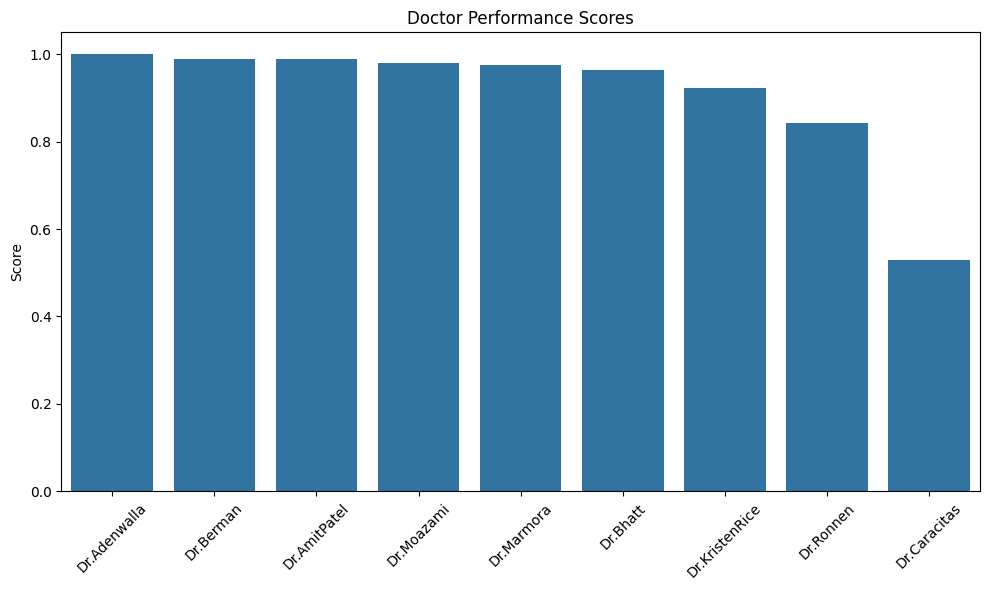

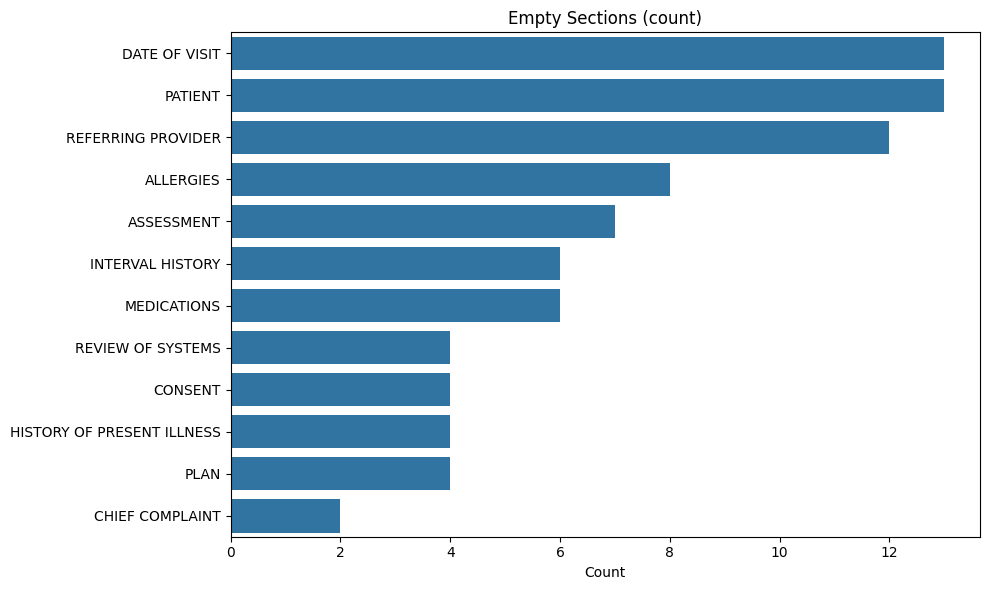

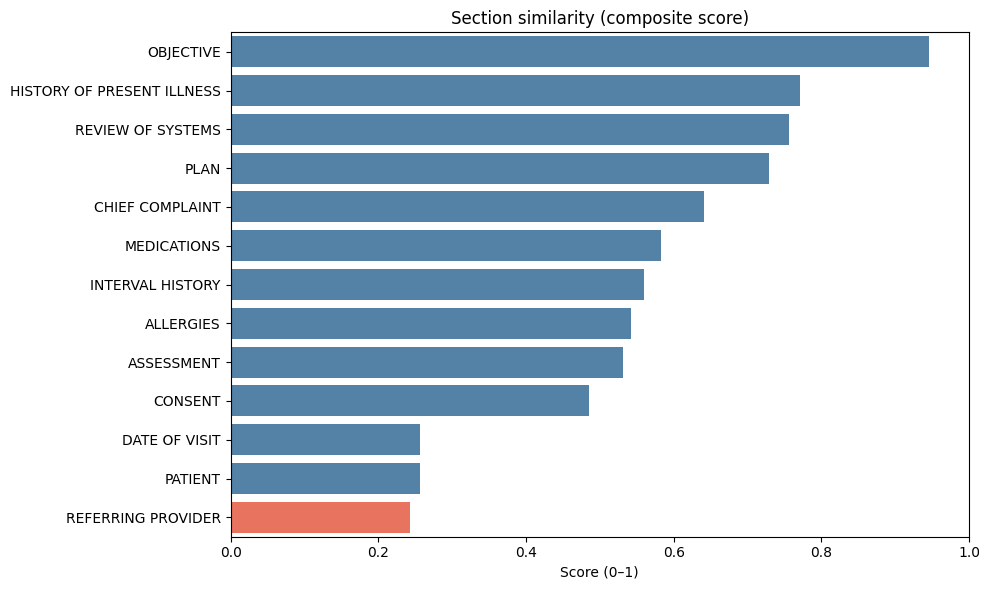

<Figure size 1000x800 with 0 Axes>

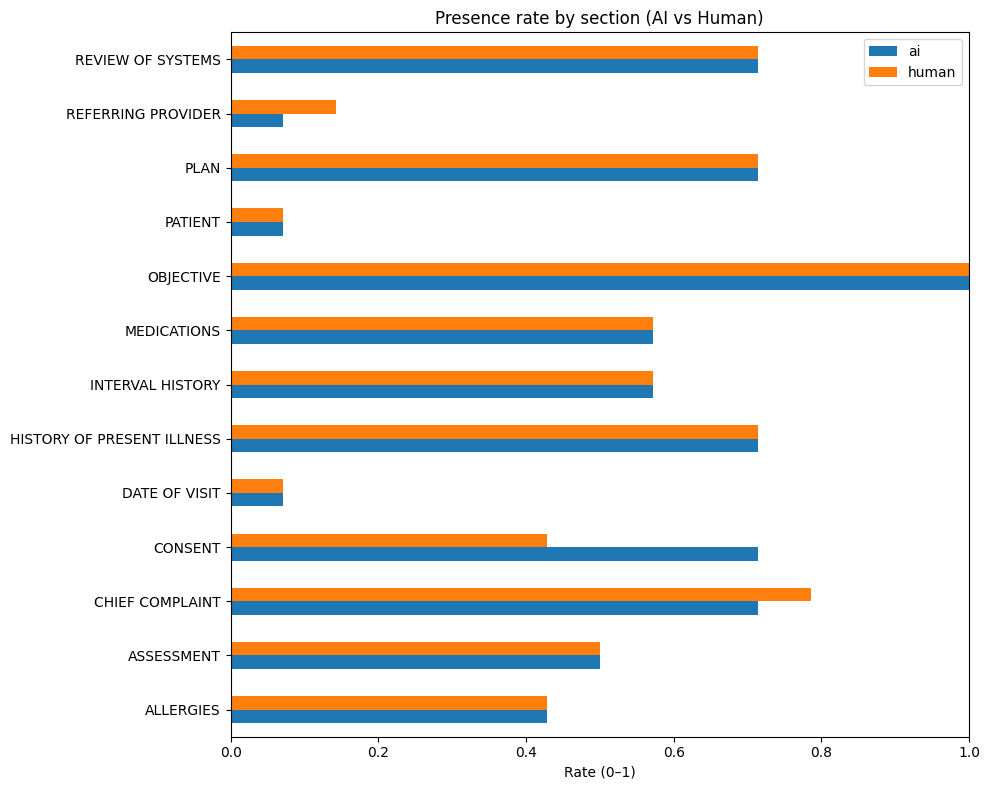

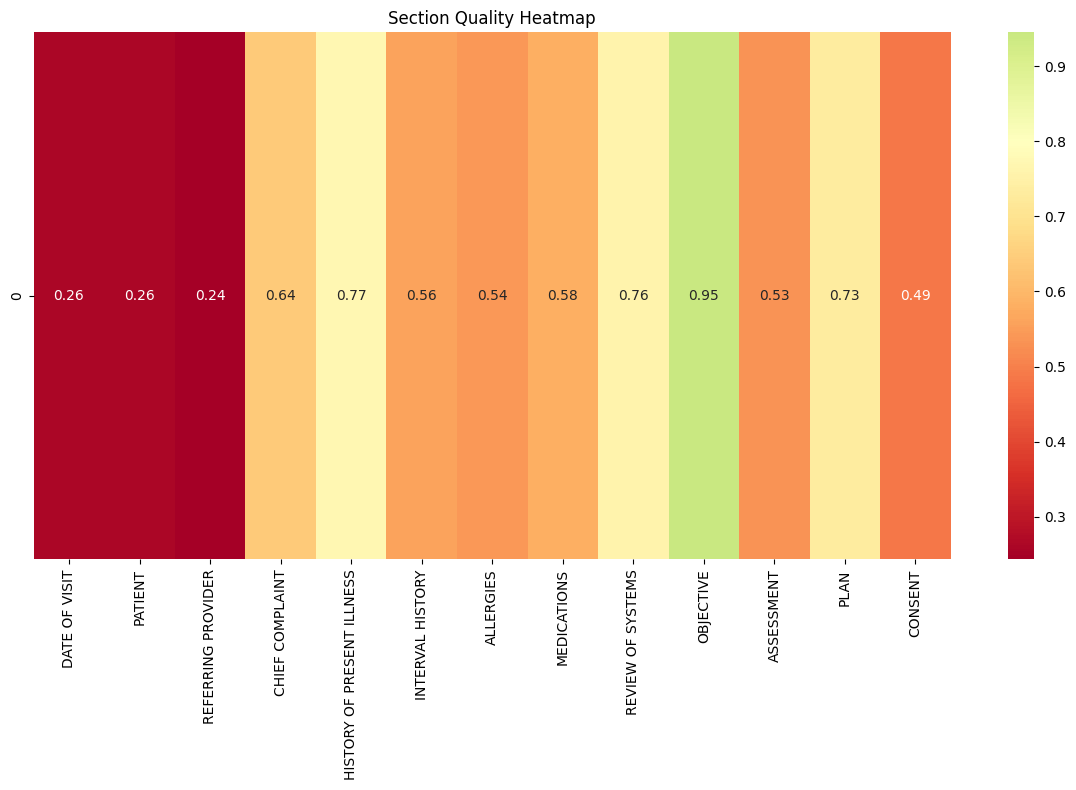

In [14]:
# Create visualizations of doctor performance and error patterns
import matplotlib.pyplot as plt
import seaborn as sns

# Plot doctor performance scores
plt.figure(figsize=(10,6))
doctor_data = json.loads(json.dumps(quality_scores, indent=2, sort_keys=True, ensure_ascii=False))
doctor_data = dict(sorted(doctor_data.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(doctor_data.keys()), y=list(doctor_data.values()))
plt.title('Doctor Performance Scores')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.tight_layout()

def plot_analysis(analysis, kind="section_scores"):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    if kind in ("empty_sections", "missing_sections", "extra_sections"):
        data = analysis[kind]
        items = sorted(data.items(), key=lambda x: x[1], reverse=True)
        labels, vals = zip(*items) if items else ([], [])
        plt.figure(figsize=(10,6))
        sns.barplot(x=list(vals), y=list(labels))
        title = kind.replace("_", " ").title()
        plt.title(f"{title} (count)")
        plt.xlabel("Count")
        plt.tight_layout()
        return

    if kind == "section_scores":
        scores = analysis["section_scores"]
        worst = analysis.get("worst_section")
        items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        labels, vals = zip(*items) if items else ([], [])
        plt.figure(figsize=(10,6))
        sns.barplot(
            x=list(vals),
            y=list(labels),
            palette=["tomato" if s == worst else "steelblue" for s, _ in items]
        )
        plt.title("Section similarity (composite score)")
        plt.xlabel("Score (0–1)")
        plt.xlim(0, 1)
        plt.tight_layout()
        return

    if kind == "presence_rates":
        pres = analysis["presence_rates"]
        df = pd.DataFrame(pres)
        df = df.loc[sorted(df.index)]
        plt.figure(figsize=(10,8))
        df.plot(kind="barh", figsize=(10,8))
        plt.title("Presence rate by section (AI vs Human)")
        plt.xlabel("Rate (0–1)")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.legend(title="")


plot_analysis(patn, kind="empty_sections")
plot_analysis(patn, kind="section_scores")
plot_analysis(patn, kind="presence_rates")

# Plot section quality heatmap
plt.figure(figsize=(12,8))
section_quality = patn["section_scores"]
quality_data = pd.DataFrame([section_quality])
sns.heatmap(quality_data, annot=True, cmap='RdYlGn', center=0.8)
plt.title('Section Quality Heatmap')
plt.tight_layout()
